<a href="https://colab.research.google.com/github/Rogerio-mack/Deep-Learning-I/blob/main/DL_TensorFlow_KerasTurner_Binary_and_Multiclass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 

<h1 align=left><font size = 6, style="color:rgb(0,0,0)"><b>Deep Learning</b></font></h1> 

# Seleção de Hyperparâmetros de Modelos com o Keras Turner
### Modelos de Classificação Binária e Multiclasse 
Rogério de Oliveira

<br>
<br>

---


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [32]:
#@title Execute antes de seguir.
#@markdown Funções pré-definidas de report de classificação e plot da curva de aprendizado.

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def print_results(y_test, y_pred):
  print('\nConfusion Matrix: \n\n', confusion_matrix(y_test, y_pred))
  print('\nClassification Report: \n\n', classification_report(y_test, y_pred))
  print('\nAccuracy Score: \n\n', accuracy_score(y_test, y_pred), '\n')
  return

def display_acc_hist(history):
  history_df = pd.DataFrame(history.history)
  print('\n\nLearning Curve... \n\n')
  print('\n', history_df.head())
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  history_df.loc[0:, [history_df.columns[1], history_df.columns[3]]].plot()

  print(("\nBest Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df[history_df.columns[2]].min(), 
              history_df[history_df.columns[3]].max()))
  print('\n ')
  return

# print_results(y_test_one, y_pred_one)
# display_acc_hist(history)



# **Binary Class Problem**

---

![imagem](https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Sagittal_balance.png/220px-Sagittal_balance.png)

<small>
<b>

Sagittal balance measurement.

## AQUISIÇÃO E EXPLORAÇÃO DOS DADOS
Variáveis preditoras e objetivo, número de classes, tipo dos dados etc.


In [33]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/rpart/kyphosis.csv',index_col=0)
df.head()

,Kyphosis,Age,Number,Start
1,absent,71,3,5
2,absent,158,3,14
3,present,128,4,5
4,absent,2,5,1
5,absent,1,4,15


## PREPARAÇÃO DOS DADOS

Seleção de atributos, tratamento de nulos, encodes, normalização etc.


In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X = df.drop(columns=['Kyphosis'])
y = df[['Kyphosis']]

# One Encode
#-------------------------------------------------------------------------------

y = y.replace({'absent':0,'present':1})

# Scale
#-------------------------------------------------------------------------------

scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = df.columns[1:4])   

# Show Results
#-------------------------------------------------------------------------------

print('\nEntradas para o Treinamento, X...\n')
display(X.head())
print('\nSaídas para o Treinamento, y....\n')
display(y.head())

# Conjuntos de Treinamento e Teste
#-------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


Entradas para o Treinamento, X...



,Age,Number,Start
0,0.341463,0.125,0.235294
1,0.765854,0.125,0.764706
2,0.619512,0.250,0.235294
3,0.004878,0.375,0.000000
4,0.000000,0.250,0.823529



Saídas para o Treinamento, y....



,Kyphosis
1,0
2,0
3,1
4,0
5,0


# Keras Tuner

Vamos empregar aqui o `Keras Tuner` para fazer o ajuste automático de hiperparâmetros.

## Instalação e import

In [35]:
!pip install -q -U keras-tuner

In [36]:
import kerastuner as kt

## Definição do Modelo

Agora nosso modelo será definido como hiperparâmetros *parametrizáveis*, isto é, indicaremos para o `Keras Tuner` um range de valores que queremos sejam avaliados na busca dos melhores hiperparâmetros. 

Existem 2 tipos de parâmetros que queremos otimizar:      

* **Hiperparâmetros do modelo** que influenciam a seleção do modelo, como o número de camadas e a quantidade de elementos em cada uma delas

* **Hiperparâmetros do algoritmo** que influenciam a velocidade e qualidade do treinamento, como a taxa de aprendizado ou o tamanho dos lotes empregados, para citar apenas parâmetros de modelos neurais de aprendizado

In [37]:
# imports
#-------------------------------------------------------------------------------

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.layers import Dropout

# Define o Modelo
#-------------------------------------------------------------------------------

def model_builder(hp):

  # Hiperparâmetros do modelo
  #----------------------------------------------------------------------------- 
  hp_units_1 = hp.Int('hp_units_1', min_value=4, max_value=64, step=4)
  hp_drop_out = hp.Choice('Dropout', values=[0.05, 0.10, 0.15, 0.20])
  hp_activaton_out = hp.Choice('activation', values=['sigmoid','tanh'])

  # Hiperparâmetros do algoritmo
  #----------------------------------------------------------------------------- 
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = keras.Sequential(layers.Dense(units=hp_units_1, activation='relu', input_shape=[X.shape[1]]))
  model.add(Dropout(hp_drop_out))
  model.add(layers.Dense(1, activation=hp_activaton_out))
  
# Compila o Modelo
#-------------------------------------------------------------------------------

  model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='binary_crossentropy', 
                metrics=['binary_accuracy'])

  return model

## Tunnig, a Busca pelos melhores Hyperparâmetros

Você pode precisar trocar o nome do `project_name=` para atualizar no Keras Turner as versões testadas do modelo.

In [38]:
# Instancia o Tuner
#-------------------------------------------------------------------------------

tuner = kt.Hyperband(model_builder,
                     objective='val_binary_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='mydir',
                     project_name='mackenzie_dl_kyphosis')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)

INFO:tensorflow:Reloading Oracle from existing project mydir/mackenzie_dl_kyphosis/oracle.json
INFO:tensorflow:Reloading Tuner from mydir/mackenzie_dl_kyphosis/tuner0.json


In [39]:
tuner.search(X_train, y_train, 
             batch_size=8,
             epochs=50, 
             validation_split=0.2, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



INFO:tensorflow:Oracle triggered exit


In [40]:
print(f"""
The hyperparameter search is complete.

The optimal hp_units_1 for de optimizer is {best_hps.get('hp_units_1')} 
The optimal Dropout for the optimizer is {best_hps.get('Dropout')} 
The optimal activation for the optimizer is {best_hps.get('activation')}
The optimal learning_rate for the optimizer is {best_hps.get('learning_rate')}
""")



The hyperparameter search is complete.

The optimal hp_units_1 for de optimizer is 16 
The optimal Dropout for the optimizer is 0.15 
The optimal activation for the optimizer is tanh
The optimal learning_rate for the optimizer is 0.001



## Treinando o modelo Final

Primeiro vamos obter a partir do modelo ótimo indicado o melhor número de épocas de Ajuste do Modelo para interromper o treinamento neste ponto.

In [41]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, 
                    batch_size=8,
                    epochs=50, 
                    validation_split=0.2,
                    verbose=0)

val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


Agora podemos treinar o modelo final.

In [42]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, 
               batch_size=8,
               epochs=best_epoch,
               validation_split=0.2)

6/6 [==============================] - 1s 36ms/step - loss: 0.5448 - binary_accuracy: 0.7955 - val_loss: 0.3031 - val_binary_accuracy: 0.9167


In [43]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

1/1 [==============================] - 0s 30ms/step - loss: 0.7164 - binary_accuracy: 0.7200
[test loss, test accuracy]: [0.7164044380187988, 0.7200000286102295]




Learning Curve... 



        loss  binary_accuracy  val_loss  val_binary_accuracy
0  1.965718         0.795455  0.388808             0.916667
1  1.384397         0.772727  0.381849             0.916667
2  1.385389         0.795455  0.383275             0.916667
3  2.621605         0.772727  0.385050             0.916667
4  1.256317         0.795455  0.393163             0.916667

Best Validation Loss: 0.3818
Best Validation Accuracy: 0.9167

 


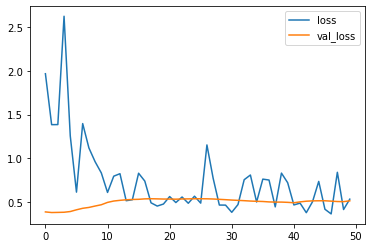

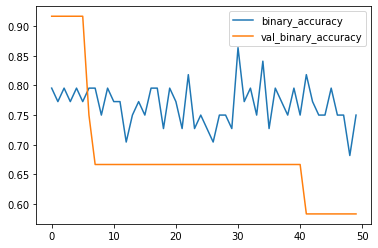

In [44]:
display_acc_hist(history)

## Avaliando o Modelo

A avaliação final é então feita sobre o conjunto de teste.

In [45]:
# Avalia o Modelo
#-------------------------------------------------------------------------------
y_pred = hypermodel.predict(X_test) > 0.5 # classes binárias, retorna a probabilidade de ser 1, então > 0.5 é classe 1, senão é classe 0

print_results(y_test, y_pred)



Confusion Matrix: 

 [[18  0]
 [ 7  0]]

Classification Report: 

               precision    recall  f1-score   support

           0       0.72      1.00      0.84        18
           1       0.00      0.00      0.00         7

    accuracy                           0.72        25
   macro avg       0.36      0.50      0.42        25
weighted avg       0.52      0.72      0.60        25


Accuracy Score: 

 0.72 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Multi Class Problem**

---

![imagem](https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/220px-Iris_versicolor_3.jpg)

<small>
<b>

Iris Versicolor.

## AQUISIÇÃO E EXPLORAÇÃO DOS DADOS
Variáveis preditoras e objetivo, número de classes, tipo dos dados etc.


In [16]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv',index_col=0)
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


## PREPARAÇÃO DOS DADOS

Seleção de atributos, tratamento de nulos, encodes, normalização etc.


In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X = df.drop(columns=['Species'])
y = df[['Species']]

# Hot Encode
#-------------------------------------------------------------------------------

hot_encode = OneHotEncoder(handle_unknown='ignore') 
hot_encode.fit(y)
y = pd.DataFrame(hot_encode.transform(y).toarray(), columns = hot_encode.categories_)  

# Scale
#-------------------------------------------------------------------------------

scaler = MinMaxScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = df.columns[0:4])   

# Show Results
#-------------------------------------------------------------------------------

print('\nEntradas para o Treinamento, X...\n')
display(X.head())
print('\nSaídas para o Treinamento, y....\n')
display(y.head())

# Conjuntos de Treinamento e Teste
#-------------------------------------------------------------------------------

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


Entradas para o Treinamento, X...



,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667



Saídas para o Treinamento, y....



,setosa,versicolor,virginica
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


# Keras Tuner

Vamos empregar aqui o `Keras Tuner` para fazer o ajuste automático de hiperparâmetros.

## Instalação e import

In [18]:
!pip install -q -U keras-tuner

In [19]:
import kerastuner as kt

## Definição do Modelo

Agora nosso modelo será definido como hiperparâmetros *parametrizáveis*, isto é, indicaremos para o `Keras Tuner` um range de valores que queremos sejam avaliados na busca dos melhores hiperparâmetros. 

Existem 2 tipos de parâmetros que queremos otimizar:      

* **Hiperparâmetros do modelo** que influenciam a seleção do modelo, como o número de camadas e a quantidade de elementos em cada uma delas

* **Hiperparâmetros do algoritmo** que influenciam a velocidade e qualidade do treinamento, como a taxa de aprendizado ou o tamanho dos lotes empregados, para citar apenas parâmetros de modelos neurais de aprendizado

In [20]:
# imports
#-------------------------------------------------------------------------------

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.layers import Dropout

# Define o Modelo
#-------------------------------------------------------------------------------

def model_builder(hp):

  # Hiperparâmetros do modelo
  #----------------------------------------------------------------------------- 
  hp_units_1 = hp.Int('hp_units_1', min_value=4, max_value=64, step=4)
  hp_units_2 = hp.Int('hp_units_2', min_value=4, max_value=64, step=4)
  hp_drop_out = hp.Choice('Dropout', values=[0.05, 0.10, 0.15, 0.20])
  hp_activaton_out = hp.Choice('activation', values=['sigmoid','tanh'])

  # Hiperparâmetros do algoritmo
  #----------------------------------------------------------------------------- 
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model = keras.Sequential(layers.Dense(units=hp_units_1, activation='relu', input_shape=[X.shape[1]]))
  model.add(Dropout(hp_drop_out))
  model.add(layers.Dense(units=hp_units_2, activation='relu'))
  model.add(Dropout(hp_drop_out))
  model.add(layers.Dense(y_train.shape[1], activation=hp_activaton_out))
  
# Compila o Modelo
#-------------------------------------------------------------------------------

  model.compile(keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

  return model

## Tunnig, a Busca pelos melhores Hyperparâmetros

Você pode precisar trocar o nome do `project_name=` para atualizar no Keras Turner as versões testadas do modelo.

In [21]:
# Instancia o Tuner
#-------------------------------------------------------------------------------

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='mydir',
                     project_name='mackenzie_dl_iris')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [22]:
tuner.search(X_train, y_train, 
             batch_size=8,
             epochs=50, 
             validation_split=0.2, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 90 Complete [00h 00m 01s]
val_accuracy: 0.190476194024086

Best val_accuracy So Far: 0.9523809552192688
Total elapsed time: 00h 02m 09s
INFO:tensorflow:Oracle triggered exit


In [23]:
print(f"""
The hyperparameter search is complete.

The optimal hp_units_1 for de optimizer is {best_hps.get('hp_units_1')} 
The optimal hp_units_2 for the optimizer is {best_hps.get('hp_units_2')} 
The optimal Dropout for the optimizer is {best_hps.get('Dropout')} 
The optimal activation for the optimizer is {best_hps.get('activation')}
The optimal learning_rate for the optimizer is {best_hps.get('learning_rate')}
""")




The hyperparameter search is complete.

The optimal hp_units_1 for de optimizer is 48 
The optimal hp_units_2 for the optimizer is 32 
The optimal Dropout for the optimizer is 0.15 
The optimal activation for the optimizer is sigmoid
The optimal learning_rate for the optimizer is 0.01



## Treinando o modelo Final

Primeiro vamos obter a partir do modelo ótimo indicado o melhor número de épocas de Ajuste do Modelo para interromper o treinamento neste ponto.

In [24]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, 
                    batch_size=8,
                    epochs=50, 
                    validation_split=0.2,
                    verbose=0)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 26


Agora podemos treinar o modelo final.

In [25]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, 
               batch_size=8,
               epochs=best_epoch,
               validation_split=0.2)

Epoch 1/26
11/11 [==============================] - 1s 23ms/step - loss: 0.9556 - accuracy: 0.6071 - val_loss: 0.7542 - val_accuracy: 0.7143
Epoch 2/26
11/11 [==============================] - 0s 4ms/step - loss: 0.6385 - accuracy: 0.7262 - val_loss: 0.5366 - val_accuracy: 0.8095
Epoch 3/26
11/11 [==============================] - 0s 6ms/step - loss: 0.4306 - accuracy: 0.8452 - val_loss: 0.4165 - val_accuracy: 0.8571
Epoch 4/26
11/11 [==============================] - 0s 6ms/step - loss: 0.3576 - accuracy: 0.8095 - val_loss: 0.3470 - val_accuracy: 0.9048
Epoch 5/26
11/11 [==============================] - 0s 6ms/step - loss: 0.2489 - accuracy: 0.9286 - val_loss: 0.3910 - val_accuracy: 0.7143
Epoch 6/26
11/11 [==============================] - 0s 4ms/step - loss: 0.2791 - accuracy: 0.8810 - val_loss: 0.4357 - val_accuracy: 0.7143
Epoch 7/26
11/11 [==============================] - 0s 6ms/step - loss: 0.3291 - accuracy: 0.8571 - val_loss: 0.3863 - val_accuracy: 0.8571
Epoch 8/26
11/11 [=

In [26]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

2/2 [==============================] - 0s 6ms/step - loss: 0.1442 - accuracy: 0.9333
[test loss, test accuracy]: [0.14422699809074402, 0.9333333373069763]




Learning Curve... 



        loss  accuracy  val_loss  val_accuracy
0  0.938481  0.583333  0.769872      0.571429
1  0.614873  0.666667  0.518824      0.714286
2  0.428844  0.785714  0.443206      0.904762
3  0.362033  0.821429  0.359964      0.904762
4  0.271798  0.916667  0.298096      0.904762

Best Validation Loss: 0.1285
Best Validation Accuracy: 1.0000

 


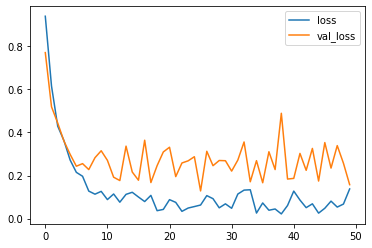

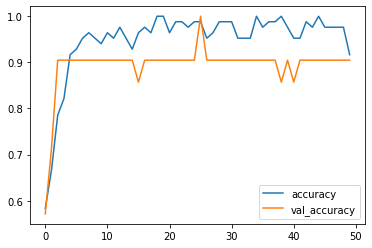

In [27]:
display_acc_hist(history)

## Avaliando o Modelo

A avaliação final é então feita sobre o conjunto de teste.

In [28]:
# Avalia o Modelo
#-------------------------------------------------------------------------------
y_pred_one = np.argmax(model.predict(X_test), axis=1)
y_test_one = np.argmax(np.array(y_test), axis=1)

print_results(y_test_one, y_pred_one)



Confusion Matrix: 

 [[18  0  0]
 [ 0  9  1]
 [ 0  4 13]]

Classification Report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.69      0.90      0.78        10
           2       0.93      0.76      0.84        17

    accuracy                           0.89        45
   macro avg       0.87      0.89      0.87        45
weighted avg       0.90      0.89      0.89        45


Accuracy Score: 

 0.8888888888888888 



# Experimente Você... 

## Dados para Classificação Binária

In [29]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/AER/HealthInsurance.csv',index_col=0)
df.head()

,health,age,limit,gender,insurance,married,selfemp,family,region,ethnicity,education
1,yes,31,no,male,yes,yes,yes,4,south,cauc,bachelor
2,yes,31,no,female,yes,yes,no,4,south,cauc,highschool
3,yes,54,no,male,yes,yes,no,5,west,cauc,ged
4,yes,27,no,male,yes,no,no,5,west,cauc,highschool
5,yes,39,no,male,yes,yes,no,5,west,cauc,none


## Dados para Classificação Multi Classe

In [30]:
df = pd.read_csv('http://meusite.mackenzie.br/rogerio/STEEL_faults.csv')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0
